# Funzioni

In [3]:
import sys
print(sys.executable)

C:\Users\andre\AppData\Local\Programs\Python\Python312\python.exe


In [7]:
import numpy as np
from scipy.stats import norm
from scipy.stats import beta as beta_dens
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

def idx2path(index, len_output_path = 10):
    binario = [int(bit) for bit in bin(index)[2:]]
    codifica_binaria = [0] * (len_output_path - len(binario)) + binario[-len_output_path:]
    return codifica_binaria

def path2idx(path):
    return int(''.join(map(str, path)), 2)

def inv_G0(p):
    return p

def count_data_in_B(data, B):
    sum = 0
    if np.isscalar(data):
      if data >= B[0] and data <= B[1]:
        sum = sum + 1
    else:
      for i in range(len(data)):
        if data[i] >= B[0] and data[i] <= B[1]:
          sum = sum + 1
    return sum

def sample_beta(a,b, size = 1):
    if size == 1:
      return np.random.beta(a, b, size=size)[0]
    else:
      return np.random.beta(a, b, size=size)

In [10]:
def polya_tree_posterior(data, c = 5, depth = 10):
    all_B = [[0,1]]
    all_alpha = [np.zeros(1)]
    for m in range(1, depth + 1):
      k = int(2 ** m)
      all_B_m = np.zeros((k, 2))
      all_alpha_m = np.zeros(k)
      for i in range(k):
        if i == 0:
          all_B_m[i,0] = 0
        else:
          all_B_m[i,0] = inv_G0(i/k)

        if i == k-1:
          all_B_m[i,1] = 1
        else:
          all_B_m[i,1] = inv_G0((i+1)/k)

        all_alpha_m[i] = c * (m**2) + count_data_in_B(data, all_B_m[i,:])

      all_B.append(all_B_m)
      all_alpha.append(all_alpha_m)

    return all_alpha, all_B

In [1]:
def sample_from_polya_tree(all_alpha):
    all_p = [1]
    depth = len(all_B) - 1
    for m in range(1,depth+1):
      k = int(2 ** m)
      all_p_m = np.zeros(k)
      all_alpha_m = all_alpha[m]
      i = 0
      while i < k:
        p = sample_beta(all_alpha_m[i], all_alpha_m[i+1])
        all_p_m[i] = p
        all_p_m[i + 1] = 1 - p
        i = i + 2
      all_p.append(all_p_m)
    N = 2 ** depth
    return_probs = np.zeros(N)
    for i in range(N):
      final_p = 1
      path = idx2path(i, len_output_path = depth)
      for m in range(1,depth + 1):
        all_p_m = all_p[m]
        final_p = final_p * all_p_m[path2idx(path[:m])]
      return_probs[i] = final_p
    return all_p, return_probs

In [12]:
def compute_predictive(all_alpha, all_B):
  depth = len(all_B) - 1
  k = 2 ** depth
  predictive_prob = np.zeros(k)
  for i in range(k):
    prob = 1
    path = idx2path(i, len_output_path=depth)
    for m in range(1, depth+1):
      index = path2idx(path[:m])
      if index % 2 == 0:
        prob = prob * all_alpha[m][index]/(all_alpha[m][index] + all_alpha[m][index+1])
      else:
        prob = prob * all_alpha[m][index]/(all_alpha[m][index] + all_alpha[m][index-1])

    predictive_prob[i] = prob
  return predictive_prob

In [13]:
def sample_from_categorical_distribution(intervals, probabilities, n):
  sampled_points = np.zeros(n)
  for i in range(n):
    selected_interval_index = np.random.choice(len(intervals), p=probabilities)
    selected_interval = intervals[selected_interval_index]
    sample = np.random.uniform(selected_interval[0], selected_interval[1])
    sampled_points[i] = sample
  return sampled_points

In [14]:
def update_alphas(old_alphas, all_B, new_data):
    new_alphas = old_alphas
    depth = len(all_B) - 1
    for m in range(1, depth + 1):
      k = int(2 ** m)
      for i in range(k):
        new_alphas[m][i] += count_data_in_B(new_data, all_B[m][i,:])

    return new_alphas

# Plot di 30 densità ~ $ PT(G_0, (A | \vec y)) ,  G_0 = U_{[0,1]} $ , e della predittiva $ P(y_{n+1} | \vec y) $




In [15]:
sample_size = 10000

# sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)
# sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)

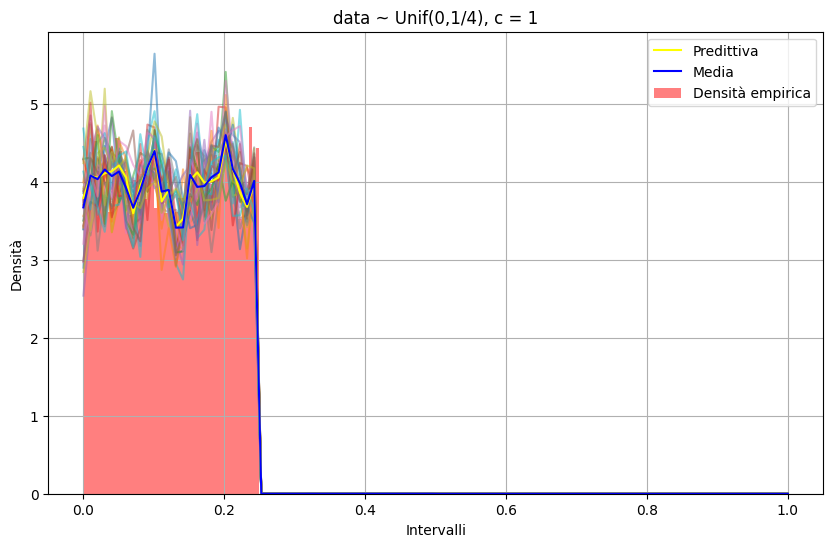

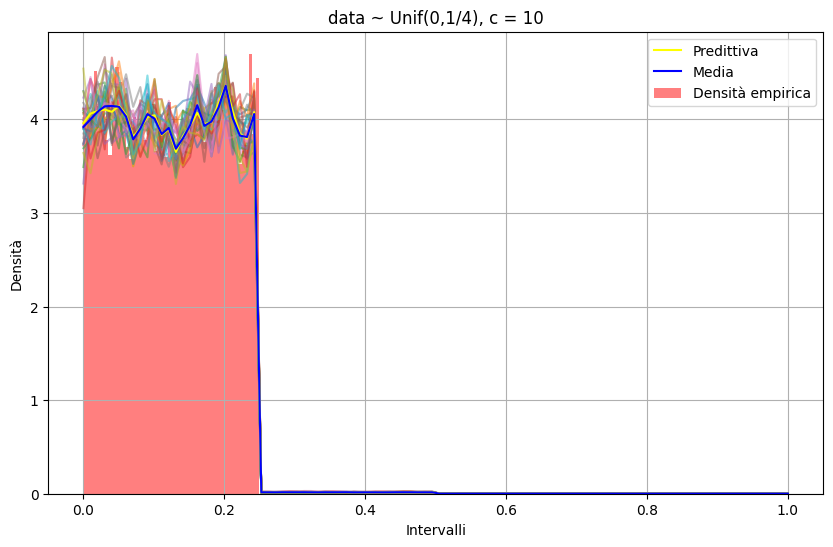

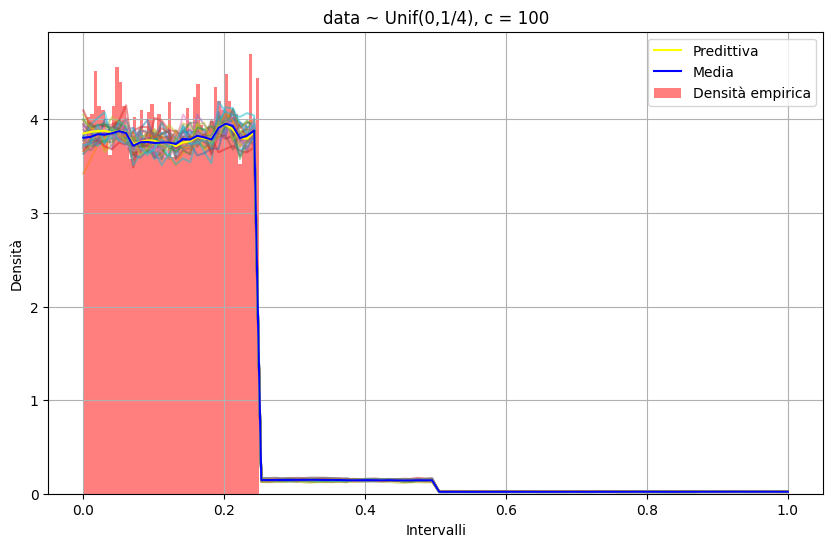

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

c_values = [1, 10, 100]                                                                       # Valori di c

num_samples = 30                                                                              # Numero di distribuzioni campionate per ogni valore di c
depth = 10

for c in c_values:
    all_alpha, all_B = polya_tree_posterior(data=sample, c=c, depth=depth)
    final_intervals = all_B[-1]
    sampled_distributions = []
    mean = 0

    # Campiona distribuzioni dal Polya Tree
    for _ in range(num_samples):
        _, sampled_distribution = sample_from_polya_tree(all_alpha)
        sampled_distributions.append(sampled_distribution)
        mean += sampled_distribution

    mean /= num_samples
    x_points = (final_intervals[:, 0] + final_intervals[:, 1]) / 2
    widths = np.diff(final_intervals, axis=1).flatten()

    plt.figure(figsize=(10, 6))

    for sampled_distribution in sampled_distributions:
        area = np.sum(sampled_distribution * widths)
        normalized_distribution = sampled_distribution / area
        f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
        x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
        y_interp = f(x_interp)
        plt.plot(x_interp, y_interp, alpha=0.5)

    sampled_distribution = compute_predictive(all_alpha, all_B)                                                        # Plot della predittiva
    area = np.sum(sampled_distribution * widths)
    normalized_distribution = sampled_distribution / area
    f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
    x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
    y_interp = f(x_interp)
    plt.plot(x_interp, y_interp, alpha=1, color="yellow", label="Predittiva")

                                                                                                                        # Plot della media
    sampled_distribution = mean
    area = np.sum(sampled_distribution * widths)
    normalized_distribution = sampled_distribution / area
    f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
    x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
    y_interp = f(x_interp)
    plt.plot(x_interp, y_interp, alpha=1, color="blue", label="Media")

    plt.hist(sample, color='red', label='Densità empirica', bins=50, density=True, alpha=0.5)

    plt.xlabel("Intervalli")
    plt.ylabel("Densità")
    plt.legend()
    plt.title(f"data ~ Unif(0,1/4), c = {c}")                                                                            # Titolo del plot
    plt.grid()
    plt.show()

# Sampling di $ m $ punti da un sample $ g$ ~ $ PT(G_0, (A | \vec y)) $  (metodo tutti insieme)

# Sampling di $ m $ punti t.c.
$ y_i $ ~ $ PT(G_0, (A | y_1 ... y_{n + i - 1} )) ~~~~\forall ~ i = n + 1 , ... , n + 1 + m$  (metodo condizionato)

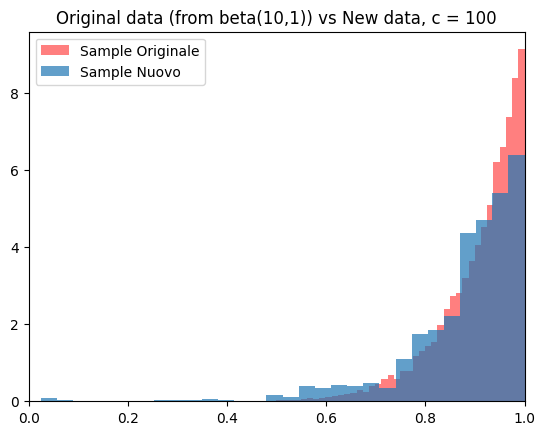

In [19]:
m = 1000
c = 100

# sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)
sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
# sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)

all_alpha, all_B = polya_tree_posterior(data = sample, c = c, depth = 10)
final_intervals = all_B[-1]
new_alphas = all_alpha

new_data = []
for i in range(m):

  if len(new_data) != 0:
    new_alphas = update_alphas(old_alphas = new_alphas, all_B = all_B, new_data = new_data[-1])

  _, g = sample_from_polya_tree(new_alphas)
  new_data.append(sample_from_categorical_distribution(intervals = final_intervals, probabilities = g, n = 1)[0])

plt.hist(sample, color='red', label='Sample Originale', density = True, bins = 50, alpha = 0.5)
plt.hist(new_data, label = "Sample Nuovo", bins = 30, density = True, alpha = 0.7)
plt.title(f"Original data (from beta(10,1)) vs New data, c = {c}")
plt.legend()
plt.xlim(0,1)
plt.show()


# Robe quantitative

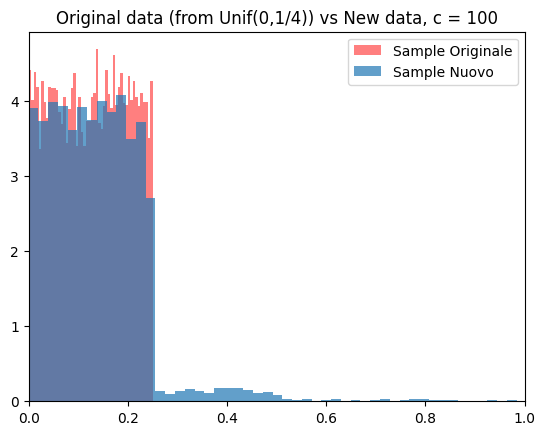

1024
1024


In [18]:
m = 10000 # numero di punti samplati
c = 100

# sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)
# sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)

all_alpha, all_B = polya_tree_posterior(data=sample, c=c, depth=depth)
_, g = sample_from_polya_tree(all_alpha)
sample_new = sample_from_categorical_distribution(intervals = final_intervals, probabilities = g, n = m)  # se campi probabilities = g con "compute_predictive(all_alpha, all_B)" fa sampling dalla predictve, ma a Mario non piace
plt.hist(sample, color='red', label='Sample Originale', bins = 50, density = True, alpha = 0.5)
plt.hist(sample_new, label = "Sample Nuovo", bins = 50, density = True, alpha = 0.7)
plt.title(f"Original data (from Unif(0,1/4)) vs New data, c = {c}")
plt.legend()
plt.xlim(0,1)
plt.show()

print(len(g))
print(len(final_intervals))

In [21]:
sample_size = 10000
depth = 10
k = 2 ** depth
f = np.zeros(k)
_, all_B = polya_tree_posterior(data=[], c=1, depth=depth)   # il valore di c è inutile, il PT mi serve solo per calcolare gli intervalli
final_intervals = all_B[-1]




sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)                 # Runnare i due blocchi insieme per ogni distribuzione, sia il sample che il ciclo for dove viene definita f
for i in range(k):                                                                           # f è la densità reale dei dati, salvata in un vettore di lunghezza 1024
  x = (final_intervals[i][0] + final_intervals[i][0])/2
  f[i] = beta_dens.pdf(x, 2, 2)
f /= sum(f)



# sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
# for i in range(k):
#   x = (final_intervals[i][0] + final_intervals[i][0])/2
#   f[i] = beta_dens.pdf(x, 10, 1)
# f /= sum(f)



# sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)
# f = np.ones(int(k/4)) * 4
# f /= sum(f)



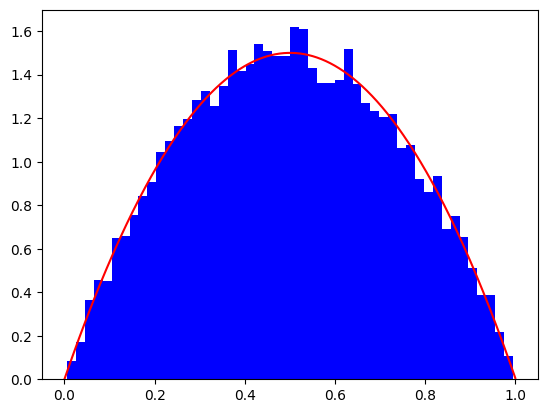

In [22]:
plt.plot(np.linspace(0,1,1024),f * 1024, color = "red")
plt.hist(sample, density = True, color = "blue", bins = 50)
plt.show()

In [23]:
c_values = [0.5, 1, 5, 10, 50, 100, 500]

num_samples = 100

L1_distances = []
Hellinger_distances = []
for c in c_values:
    all_alpha, all_B = polya_tree_posterior(data=sample, c=c, depth=depth)
    final_intervals = all_B[-1]
    L1_distance = []
    Hellinger_distance = []

    for _ in range(num_samples):
        _, g = sample_from_polya_tree(all_alpha)
        L1_distance.append(np.sum(np.abs(g - f))/k)                                   # L1 distance
        Hellinger_distance.append(np.sum(((np.sqrt(g) - np.sqrt(f))**2))/k)           # H distance

    L1_distances.append(L1_distance)
    Hellinger_distances.append(Hellinger_distance)


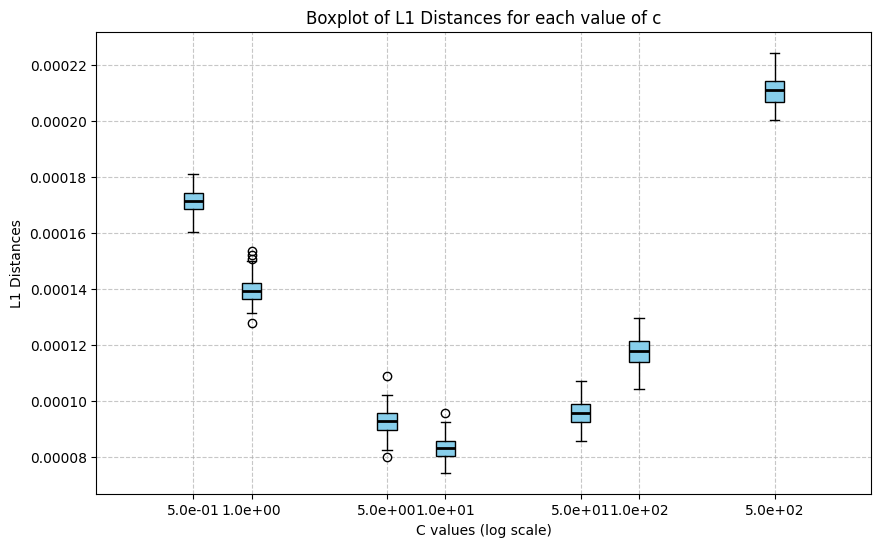

In [24]:
plt.figure(figsize=(10, 6))
box = plt.boxplot(
    L1_distances,
    # Hellinger_distances,                                            # Cambiare qui e il blocco sotto per plottare Hellinger (commentando il blocco con le distanze L1)
    positions=np.log10(c_values),
    widths=0.1,
    patch_artist=True
)

uniform_color = 'skyblue'
for patch in box['boxes']:
    patch.set_facecolor(uniform_color)
    patch.set_edgecolor('black')

for median in box['medians']:
    median.set_color('black')
    median.set_linewidth(2)


plt.xscale('linear')
plt.xticks(np.log10(c_values), labels=[f"{c:.1e}" for c in c_values])
plt.xlabel('C values (log scale)')

plt.ylabel('L1 Distances')
plt.title('Boxplot of L1 Distances for each value of c')

# plt.ylabel('Hellinger Distances')
# plt.title('Boxplot of Hellinger Distances for each value of c')

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


# $\varepsilon$ differential privacy
choosing a small c is beneficial in the sense of a high level of privacy mantained, as data are highly modified according to the PT posterior distribution. </br> 
However, it's for big values of c that $\varepsilon$ tends to 0


## General formulation

Q_x denotes the predictive distribution generated from the original dataset data_x
</br> Q_y denotes the predictive distribution generated from the modified dataset dataset_y (where only the last element has been changed)

## Lazzarin Algorithm



In [ ]:
J, K, L = 100, 100, 100

c = 0.01
depth = 10

n = 1000
m = 100

for k in range(K):
    data_x = np.random.beta(2, 2, n)
    all_alpha_x, all_B_x = polya_tree_posterior(data = data_x, c = c, depth = depth)
    for l in range(L):

        # FERMO QUI - NON SO SERVE EFFETTIVAMENTE Z OPPURE NO

        # Successivamente calcolo il rapporto e vado a selezionare c ed m per ottenere il minimo

In [297]:
sample_size = 10

# data_x = np.random.uniform(0, 1/4, sample_size)
# data_y = np.append(data_x[:-1], np.random.uniform(0, 1/4))
data_x = np.random.beta(2, 2, sample_size)
data_y = np.append(data_x[:-1], np.random.beta(2, 2))

c = 0.01
depth = 10
all_alpha_x, all_B_x = polya_tree_posterior(data = data_x, c = c, depth = depth)
Q_x = compute_predictive(all_alpha_x, all_B_x)
all_alpha_y, all_B_y = polya_tree_posterior(data = data_y, c = c, depth = depth)
Q_y = compute_predictive(all_alpha_y, all_B_y)


I want to get the ratio of the predictive for the original and the modified dataset to see $\varepsilon$, the smaller it is, the better

In [218]:
def dataset_predictive (b, intervals, probabilities):

    # function that evaluates the predictive distribution in b (which is a dataset), 
    # given the dataset X=x already observed. i.e., it computes Q(B=b|X=x)

    product = 1
    for i in range(len(b)):
        index = next((j for j in range(len(intervals)) if intervals[j][0] <= b[i] < intervals[j][1]), -1)
        product *= probabilities[index]

    return product

def eps_diff_privacy(b, intervals_x, probabilities_x, intervals_y, probabilities_y):
    
    # function that computes the ratio Q(b|X=x) / Q(b|X=y) and the relative epsilon

    ratio_x_over_y = dataset_predictive(b, intervals_x, probabilities_x) / dataset_predictive(b, intervals_y, probabilities_y)
    ratio = max(ratio_x_over_y, 1/ratio_x_over_y)  #it's not good if the ratio is either too big or too small

    if dataset_predictive(b, intervals_x, probabilities_x) == 0 and dataset_predictive(b, intervals_y, probabilities_y) == 0:
        ratio = 1
        
    eps = np.log(ratio).item()
    return eps

# b = np.random.uniform(0,1/4,sample_size)
b = np.random.beta(2,2,sample_size)

eps = eps_diff_privacy(b, all_B_x[-1], Q_x, all_B_y[-1], Q_y)
print(f'eps = {eps}')       #values of eps very similar to 0 denote that ratio Q(b|X=x) / Q(b|X=y) is very similar to 1 
print(f'e^eps = {np.exp(eps)}')

C:\Users\133123\AppData\Local\Temp\ipykernel_18700\1302621295.py:12: RuntimeWarning: invalid value encountered in scalar divide
  ratio_x_over_y = dataset_predictive(b, intervals_x, probabilities_x) / dataset_predictive(b, intervals_y, probabilities_y)


eps = 0.0
e^eps = 1.0


To see an example on how $\varepsilon$ changes w.r.t. $c$

Text(0.5, 1.0, 'eps')

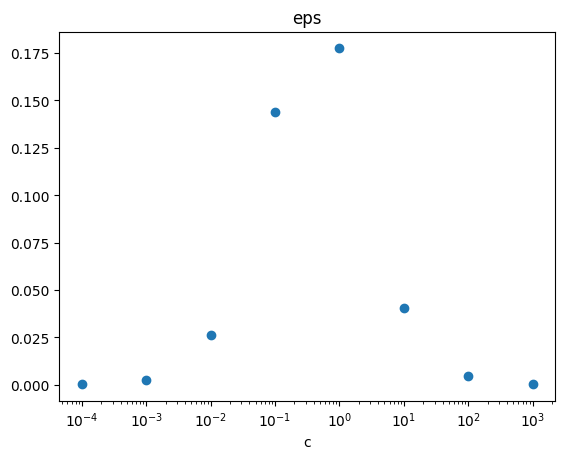

In [287]:
# Now we sample two random starting datasets data_x and data_y, one random sampled dataset b for the evaluation
# We let c vaty to see how eps changes

# output is always different as we did not already compute the sup(all modified datasets y), nor the sup(all evaluation datasets b)


c_values = 10**np.arange(-4, 4, dtype = float)

depth = 10
# data_x = np.random.uniform(0, 1/4, sample_size)
# data_y = np.append(data_x[:-1], np.random.uniform(0, 1/4))
data_x = np.random.beta(2, 2, sample_size)
data_y = np.append(data_x[:-1], np.random.beta(2, 2))

# b = np.random.uniform(0,1/4,sample_size)
b = np.random.beta(2,2,sample_size)

eps_vector=[]


for c in c_values:
    all_alpha_x, all_B_x = polya_tree_posterior(data = data_x, c = c, depth = depth)
    Q_x = compute_predictive(all_alpha_x, all_B_x)
    all_alpha_y, all_B_y = polya_tree_posterior(data = data_y, c = c, depth = depth)
    Q_y = compute_predictive(all_alpha_y, all_B_y)
    eps_vector.append(eps_diff_privacy(b, all_B_x[-1], Q_x, all_B_y[-1], Q_y))

plt.xscale("log")
plt.xlabel("c")
plt.plot(c_values, eps_vector, 'o')
plt.title("eps")


To see an example on how $\varepsilon$ changes with sample_size (doesn't seem to influence much)

2
4
10
21
46
100


Text(0.5, 1.0, 'eps')

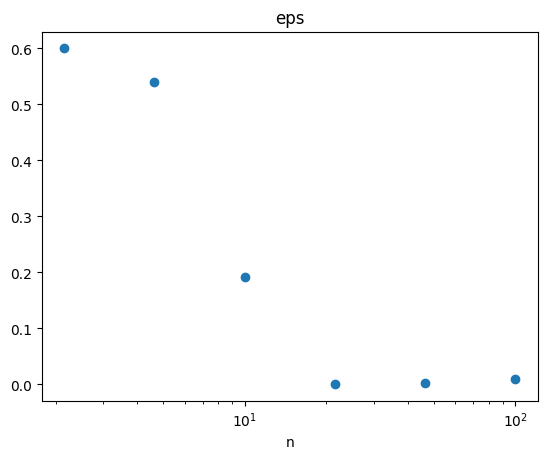

In [246]:
# Repeat, but now keep c = 1 fixed and let sample_size (number of observations in the dataset) vary

sample_size_values = 10**(np.arange(1, 7, dtype = float)/3)

depth = 10
c = 1
eps_vector=[]


for sample_size in sample_size_values:

    sample_size = int(sample_size)
    print(sample_size)

    # data_x = np.random.uniform(0, 1/4, sample_size)
    # data_y = np.append(data_x[:-1], np.random.uniform(0, 1/4))
    data_x = np.random.beta(2, 2, sample_size)
    data_y = np.append(data_x[:-1], np.random.beta(2, 2))
    
    # b = np.random.uniform(0,1/4,sample_size)
    b = np.random.beta(2,2,sample_size)
    
    all_alpha_x, all_B_x = polya_tree_posterior(data = data_x, c = c, depth = depth)
    Q_x = compute_predictive(all_alpha_x, all_B_x)
    all_alpha_y, all_B_y = polya_tree_posterior(data = data_y, c = c, depth = depth)
    Q_y = compute_predictive(all_alpha_y, all_B_y)
    eps_vector.append(eps_diff_privacy(b, all_B_x[-1], Q_x, all_B_y[-1], Q_y))

plt.xscale("log")
plt.xlabel("n")
plt.plot(sample_size_values, eps_vector, 'o')
plt.title("eps")

Since sample_size does not seem to be that meaningful, we don't even try to cycle on both together

## Computing the sup sup

Now, to state wheter our model satisfies $\varepsilon$-differential_privacy, we must compute the sup w.r.t.:
</br> - all the modified datasets y
</br> - all the possible b's
</br> We could do that with for loops

### Looking for the maximum of $\varepsilon$ over all possible b

To compute the sup for all possible b's, let's try to cover the domain of the dataset, which is $[0,1]^{sample\ size}$, the more uniformly that we can

In [25]:
# With this function I can generate all possible b's

def generate_vectors(steps, num_elements):

    values = np.linspace(0, 1/4, steps + 1) 
    mesh = np.meshgrid(*[values] * num_elements)  
    vectors = np.column_stack([m.ravel() for m in mesh])  

    return vectors  

# Example usage
steps = 13  # Number of steps for each element
num_elements = 4  # Number of elements in each vector         (IDEALLY, num_elements SHOULD BE EQUAL TO sample_size, BUT TOO MANY COMPUTATIONALLY EXPENSIVE)

matrix = generate_vectors(steps, num_elements)
matrix.shape

# This matrix stores as rows all the different b I want (supposing len(b) = num_elements)

(38416, 4)

Looking for the maximum of $\varepsilon$ over all possible b

In [306]:
max_eps = -10
for i in range(matrix.shape[0]):
    b = matrix[i,:]
    eps = eps_diff_privacy(b, all_B_x[-1], Q_x, all_B_y[-1], Q_y)
    max_eps = max(eps, max_eps)
print(f'eps = {max_eps}')
print(f'e^eps = {np.exp(max_eps)}')

eps = 8.483267571175212
e^eps = 4833.217003334123


#### doing that with c that varies

eps = 0.001398970180325507
e^eps = 1.0013999491955927
eps = 0.013897675454210624
e^eps = 1.0139946970830787
eps = 0.13038016395384305
e^eps = 1.139261407130381
eps = 0.7950998411890076
e^eps = 2.214662100263615
eps = 1.1909296332211297
e^eps = 3.2901384080915497
eps = 0.3438895151470389
e^eps = 1.4104227965436253
eps = 0.041759028630981306
e^eps = 1.0426432013170261
eps = 0.004267365502249318
e^eps = 1.0042764836719882


Text(0.5, 0, 'c')

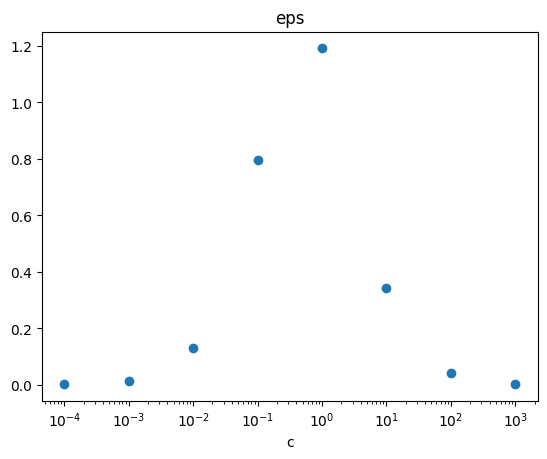

In [285]:
#(6m long run)

# With this, we can look how the sup(over b) varies with different values of c

sample_size = 10
c_vector = 10**np.arange(-4, 4, dtype = float)
max_eps_vector = []
depth = 10

# data_x = np.random.uniform(0, 1/4, sample_size)
# data_y = np.append(data_x[:-1], np.random.uniform(0, 1/4))
data_x = np.random.beta(2, 2, sample_size)
data_y = np.append(data_x[:-1], np.random.beta(2, 2))

for c in c_vector:

    all_alpha_x, all_B_x = polya_tree_posterior(data = data_x, c = c, depth = depth)
    Q_x = compute_predictive(all_alpha_x, all_B_x)
    all_alpha_y, all_B_y = polya_tree_posterior(data = data_y, c = c, depth = depth)
    Q_y = compute_predictive(all_alpha_y, all_B_y)

    max_eps = -10
    for i in range(matrix.shape[0]):
        b = matrix[i,:]
        eps = eps_diff_privacy(b, all_B_x[-1], Q_x, all_B_y[-1], Q_y)
        max_eps = max(eps, max_eps)
    
    max_eps_vector.append(max_eps)
    print(f'eps = {max_eps}')
    print(f'e^eps = {np.exp(max_eps)}')

plt.xscale("log")
plt.plot(c_vector, max_eps_vector, 'o')
plt.title("eps")
plt.xlabel("c")

### Looking for the maximum of $\varepsilon$ over all possible modified datasets $X = y$

To compute the sup for all possible modified datasets (where each time only one observation changes) a solution could be to take each time a observation of x and change it with a random sample from the same law of the observations of dataset x. Though it would be better to cover the domain uniformly also in this case. But I'm afraid it would be a too long run

In [273]:
# With this function I can generate all possible modified datasets
sample_size = 10
replacement_batch = 11
# data_x = np.random.uniform(0, 1/4, sample_size)
data_x = np.random.beta(2, 2, sample_size)         #we replace one of the data_x observations with ...
   
# b = np.random.uniform(0,1/4,sample_size)
b = np.random.beta(2, 2, replacement_batch)                # ... replacement vector: we use a one of 10000 samples of the distribution to substitute the element in data_x

def build_substitution_matrix(d, r):
        
        d = np.array(d)  # Ensure d is a numpy array
        r = np.array(r)  # Ensure r is a numpy array
        if len(d) > 10 and len(r) > 10:
            print("Too high dimensions")
            return()
        
        rows = []
        for i in range(len(d)):
            for val in r:
                row = d.copy()  # Copy the original vector
                row[i] = val    # Substitute the element
                rows.append(row)

        return d, np.array(rows)

data_x, matrix = build_substitution_matrix(data_x, b)
matrix.shape

(110, 10)

In [276]:
max_eps = -10
for i in range(matrix.shape[0]):

    data_y = matrix[i,:]

    c = 1
    depth = 10
    all_alpha_x, all_B_x = polya_tree_posterior(data = data_x, c = c, depth = depth)
    Q_x = compute_predictive(all_alpha_x, all_B_x)
    all_alpha_y, all_B_y = polya_tree_posterior(data = data_y, c = c, depth = depth)
    Q_y = compute_predictive(all_alpha_y, all_B_y)

    eps = eps_diff_privacy(b, all_B_x[-1], Q_x, all_B_y[-1], Q_y)
    max_eps = max(eps, max_eps)
    
print(f'eps = {max_eps}')
print(f'e^eps = {np.exp(max_eps)}')

eps = 0.3675940271591993
e^eps = 1.4442555913957578


#### doing that with c that varies

eps = 17.232861891507472
e^eps = 30488553.97112813
eps = 14.435561615197539
e^eps = 1859022.9559920034
eps = 9.308989842380202
e^eps = 11036.793594659002
eps = 2.802250242774844
e^eps = 16.481692884420795
eps = 0.3675940271591993
e^eps = 1.4442555913957578
eps = 0.15358032012958678
e^eps = 1.1660014367475848
eps = 0.03160070421007643
e^eps = 1.032105307712086
eps = 0.0035189510991909586
e^eps = 1.0035251498765423


Text(0.5, 0, 'c')

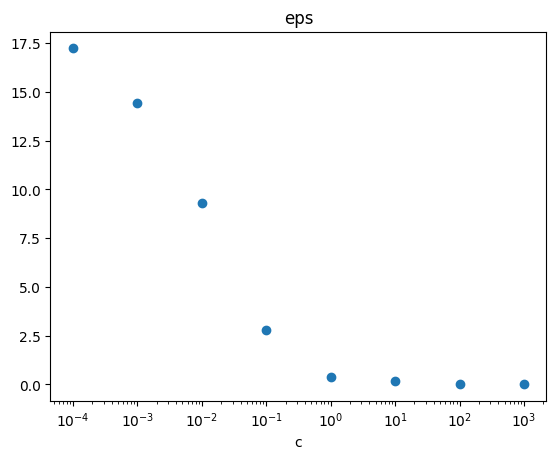

In [278]:
# With this, we can look how the sup(over y) varies with different values of c

c_values = 10**np.arange(-4, 4, dtype = float)
max_eps_vector = []

for c in c_values:

    max_eps = -10
    for i in range(matrix.shape[0]):

        data_y = matrix[i,:]

        depth = 10
        all_alpha_x, all_B_x = polya_tree_posterior(data = data_x, c = c, depth = depth)
        Q_x = compute_predictive(all_alpha_x, all_B_x)
        all_alpha_y, all_B_y = polya_tree_posterior(data = data_y, c = c, depth = depth)
        Q_y = compute_predictive(all_alpha_y, all_B_y)

        eps = eps_diff_privacy(b, all_B_x[-1], Q_x, all_B_y[-1], Q_y)
        max_eps = max(eps, max_eps)
    max_eps_vector.append(max_eps)

    print(f'eps = {max_eps}')
    print(f'e^eps = {np.exp(max_eps)}')

plt.xscale("log")
plt.plot(c_values, max_eps_vector, 'o')
plt.title("eps")
plt.xlabel("c")